In [2]:
# authors: nmg, pbg
# phy5905 sp22
# project 2

# import packages
import numpy as np
import math
import matplotlib.pyplot as plt

import astropy.units as u
import astropy.constants as const

## Physics

Reference: [MIT 8.01 lecture notes](http://web.mit.edu/8.01t/www/materials/Presentations/old_files_f07/Presentation_W14D1.pdf) 

Two-body framework:
* $\overrightarrow{r_1}$: distance from origin to $M_1$ 
* $\overrightarrow{r_2}$: distance from origin to $M_2$
* $\overrightarrow{r}_{CM} = \frac{m_1\overrightarrow{r_1} + m_2\overrightarrow{r_2}}{m_1 + m_2} $
  * $\overrightarrow{r}_{CM}$: distance from origin to center of mass
* $ \mu = \frac{m_1 m_2}{m_1 + m_2}$, reduced mass
* $\overrightarrow{r}$: distance between $M_1$ and $M_2$ 
  * $\overrightarrow{r} = \overrightarrow{r_1} - \overrightarrow{r_2}$
  
We can also get the vectors from the center of mass to $M_1$ and $M_2$:
$$ \overrightarrow{r_1}'  = \overrightarrow{r_1} - \overrightarrow{r_{CM}}$$
$$ \overrightarrow{r_1}'  = \overrightarrow{r_1} - \frac{m_1\overrightarrow{r_1} 
+ m_2\overrightarrow{r_2}}{m_1 + m_2}  $$
$$ \overrightarrow{r_1}'  = \frac{m_2 (\overrightarrow{r_1} - \overrightarrow{r_2})}{m_1 + m_2} $$

We now have expressions for the position vector of each mass with respect to
the center of mass:
* $ \overrightarrow{r_1}' = \frac{\mu}{m_1}\overrightarrow{r}$
* $ \overrightarrow{r_2}' = \frac{\mu}{m_2}\overrightarrow{r}$

By rewriting the two-body problem to a single-body, reduced-mass problem, we 
have an expression for $\overrightarrow{r}$:
$$ \overrightarrow{r_0} = \frac{p}{1 + e cos(\phi)} $$

We also can express the angle between each mass and the semimajor axis or axis
of closest approach as $\phi$:
$$ \phi_{0} = \phi_{0,1} = -\phi_{0,2} $$

We can use this expression $r(\phi)$ to find initial values for $ \overrightarrow{r_1}'$ 
and $ \overrightarrow{r_2}'$, and then express these in Cartesian coordinates.

Here are the expressions for $m_1$: 
* $ x_{0,1} = r_{0,1}' cos \phi_{0,1} $
* $y_{0,1} = r_{0,1}' sin \phi_{0,1} $
* $\dot{x_{0,1}} = -r_{0,1}'sin \phi_{0,1} \dot{\phi_{0,1}} + \dot{r_{0,1}}' cos \phi_{0,1}$
* $ \dot{y_{0,1}} = r_{0,1}' cos \phi_{0,1} \dot{\phi_{0,1}} + \dot{r_{0,1}}' sin \phi_{0,1}$

  


## Computation

Reference: [A Simple Leapfrog Integration Scheme to Find Optimal Interplanetary Trajectories by Scott M. Kelley](https://ir.library.oregonstate.edu/downloads/cc08hm643)

The basic equations of motion of the leapfrog integration scheme are

$$r_{i+1} = r_i + v_{i+\frac{1}{2}} \Delta t \\
v_{i+\frac{1}{2}} = v_{i-\frac{1}{2}} + a_i \Delta t. $$

This system of equations can be rewritten without the explicit use of half-steps by first
expressing the velocity term for a full step in two distinct half-steps

$$v_{i+\frac{1}{2}} = v_{i-\frac{1}{2}} + a_i \Delta t \\
v_{i+1} = v_{i+\frac{1}{2}} + \frac{a_{i+1}}{2} \Delta t. $$

Combining above equations allows the equations of motion to be written strictly in terms of integer timesteps:

$$r_{i+1} = r_i + v_i \Delta t + \frac{a_i}{2}\Delta t^2 \\
v_{i+1} = v_i + \frac{(a_i + a_{i+1})}{2} \Delta t $$

In [3]:
def f(rs, **kwargs):
    """
    Evaluate the second derivative of the position vector in 2D.
    
    Inputs:  array with x-, y- components of the position vector
    Returns: array of x-,y- components of acceleration 
             evaluated at these points
    """
    # position of mass1, mass2    
    x1, y1 = rs[0], rs[1]  
    x2, y2 = rs[2], rs[3] 
    r = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    
    # x, y components of Acceleration 'a'
    ax1 = G*m2*(x2 - x1)/r**3    
    ay1 = G*m2*(y2 - y1)/r**3    
    ax2 = G*m1*(x1 - x2)/r**3    
    ay2 = G*m1*(y1 - y2)/r**3    
    
    return np.array([ax1, ay1, ax2, ay2], float)
    

In [4]:
def get_energy(r, vi):
    """
    Calculate vis-viva energy for two masses
    
    Inputs:
        r, 1-D array of (x1, y1, x2, y2)
        vi, 1-D array of (vx1, vy1, vx2, vy2)
    Returns:
        energy, v**2/2 - mu/r
    
    """
    
    x1, y1, x2, y2 = r
    vx1, vy1, vx2, vy2 = vi
    
    r12 = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    v12 = np.sqrt((vx2 - vx1)**2 + (vy2 - vy1)**2)
    
    vve = 0.5*v12**2 - mu/r12
    E = 0.5*mu*v12**2 - G*m1*m2/r12
    
    return E
    

In [5]:
def get_err(truth, computed):
    """Calculate relative error"""
    if truth == 0.:
        print("using alt err")
        err = truth - computed
    else: 
        err = (truth - computed)/truth
    return err

In [17]:
def leapfrog(t0, tmax, r0, phi0, dphi0, dr0, h, f, err_tol, **kwargs):
    """                                                                                                                      
    Calculate a soln r(t) to a 1st-order ODE of the form r'(t)=f(r,t).                                                 
                                                                                                                             
    Uses the leapfrog method.    
    
    Inputs: 
    t0 & tmax (Init & final time) 
    r0, phi0 (Init pos, angle of reduced mass, mu)
    dphi0, dr0 (initial angular, radial velocity of mu)
    h (step size)
    f (function to obtain accelaration)
    err_tol: amount of allowed error in Energy calculation
    
    Returns: 
    t (array for time steps)
    X & Y (arrays for position coordinates of both objects)
    v_ (array of velocities of both objects)
    err (array for relative err in position)
    
    """
    
    debug = False
    
    x0 = r0 * np.cos(phi0)
    y0 = r0 * np.sin(phi0)
    vx0 = -r0 * np.sin(phi0)*dphi0 + np.cos(phi0)*dr0
    vy0 = r0 * np.cos(phi0)*dphi0 + np.sin(phi0)*dr0
    
    # convert from one-body reduced-mass to two-body problem
    x1, y1 = (mu/m1)*x0, (mu/m1)*y0 
    x2, y2 = -(mu / m2)*x0, -(mu / m2)*y0 
    vx1, vy1 = (mu/m1)*vx0, (mu/m1)*vy0 
    vx2, vy2 = -(mu / m2)*vx0, -(mu / m2)*vy0 
    
    # Initialize array for time at each step
    ti = t0
    t = np.array(ti)
    
    # initialize arrays of positions at each step
    r = np.array([x1, y1, x2, y2], float)
    R = np.array([r])
    
    # initialize arrays of velocities at each step
    vinit = np.array([vx1, vy1, vx2, vy2], float)
    v_ = np.array([vinit]) 
    vi = vinit
    
    # track relative error between initial Energy, calculated Energy 
    E_now = get_energy(r,vi)
    # total energy of system, E = KE + PE
    E_ref = 0.5*mu*(vx0**2 + vy0**2) - G*m1*m2/r0
    
    rel_err = get_err(E_ref, E_now)
    #print(f"t=0: E_ref: {E_ref}, rel_err: {rel_err}")
    err = np.array([rel_err])
    global E
    E = np.array([E_now])
    
    # solve eqns of motion using leapfrog method
    while np.abs(rel_err) < err_tol:
        # break if t = tmax
        if ti > tmax:
            if debug: print(f"Time: {ti} > {tmax}")
            break
        else:
            # update t, r, v_mid
            ti += h
            ri = r +  h*vi + 0.5*f(r)*h**2
            vi = vi + 0.5*h*(f(r) + f(ri))
            r = ri
            Ei = get_energy(r, vi)
            
            # calculate new rel error
            # print(f"dE: {E_ref - get_energy(r, vi)}")
            #rel_err = get_err(E_ref, get_energy(r, vi))
            #print(f"err: {rel_err}")
            
            # save t, r, phi_mid
            t = np.append(t, ti)
            R = np.append(R, np.array([r]), axis=0)
            v_ = np.append(v_, np.array([vi]), axis=0)
            err = np.append(err, rel_err) # relative error
            E = np.append(E, Ei)    # total energy
    
    # components of cartesian coords
    # R: [x1, x2, y1, y2]
    X = R[:,[0,2]]  # x1, x2
    Y = R[:,[1,3]]  # y1, y2
    # calculate error using either relative error or mean of E 
    print(f"E_ref = {E_ref}, |mean(E)| = {np.abs(np.mean(E))}")
    #err = (E_ref - E) / np.max((np.abs(E_ref), np.abs(np.mean(E))))
    #err = (E - E_ref) / (E_ref, d)
    
    return t, X, Y, v_, err

In [36]:
# UNITS: kpc, Msun, Myr
# constants
G = (const.G).to(u.kpc**3 * u.Msun**-1 * u.Myr**-2).value # kpc^3/Msun/Myr

# tunable orbit parameters
m1 = 1e12 # Msun
m2 = 1e12 # Msun
rmin = 25 # kpc #for parabolic encounter
a = rmin # (G*M*T**2/(4*np.pi**2))**(1/3)   # semi-major axis (kpc, Kepler's Law)
ecc = 1. # eccentricity

# calculated parameters
M = m1 + m2
mu = m1*m2 / M
P = np.sqrt((4*np.pi**2*a**3)/(G*M))

# runtime initial conditions
t0, tmax = 0, 800 # 5*P # 5000
h = 1 #1e-3

# define values for p, error calculation
if ecc == 1.:      # parabolic orbit
    print("parabolic orbit")
    p = 2 * rmin  
    err_tol = 20  # arbitrary value because E = 0
elif (ecc > 0.) & (ecc < 1.): # closed orbit, elliptical
    print("elliptical orbit")
    p = a * (1 - ecc**2)
    err_tol = 1e-5
else: # closed orbit, circular
    print("circular orbit")
    p = a
    err_tol = 1e-5


# choose initial position, motion of reduced-mass galaxy pair relative to 
#    semi-major axis or axis of closest approach
phi0 = 0.5*np.pi # np.pi*(2*np.random.rand() - 1) 
r0 = p / (1 + ecc * np.cos(phi0))
dphi0 = np.sqrt(G*M*p) / r0**2
dr0 = ecc * r0**2 * np.sin(phi0) * dphi0 / p

print(f"initial r0, phi0: {r0:.5} kpc, {phi0:.5} rad")

parabolic orbit
initial r0, phi0: 50.0 kpc, 1.5708 rad


In [37]:
# leapfrog(t0, tmax, r0, v0, h, f, r_ref, err_tol, **kwargs)
t, X, Y, v_, err =  leapfrog(t0, tmax, r0, phi0, dphi0, dr0, h, f, err_tol)


E_ref = 1.52587890625e-05, |mean(E)| = 744896.9443751357


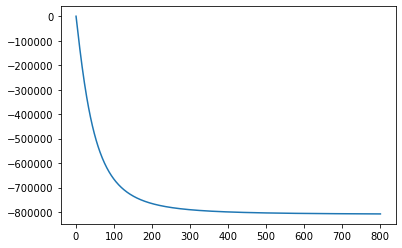

In [38]:
plt.plot(E)

cumulative error over 801 Myr: 0.0 .


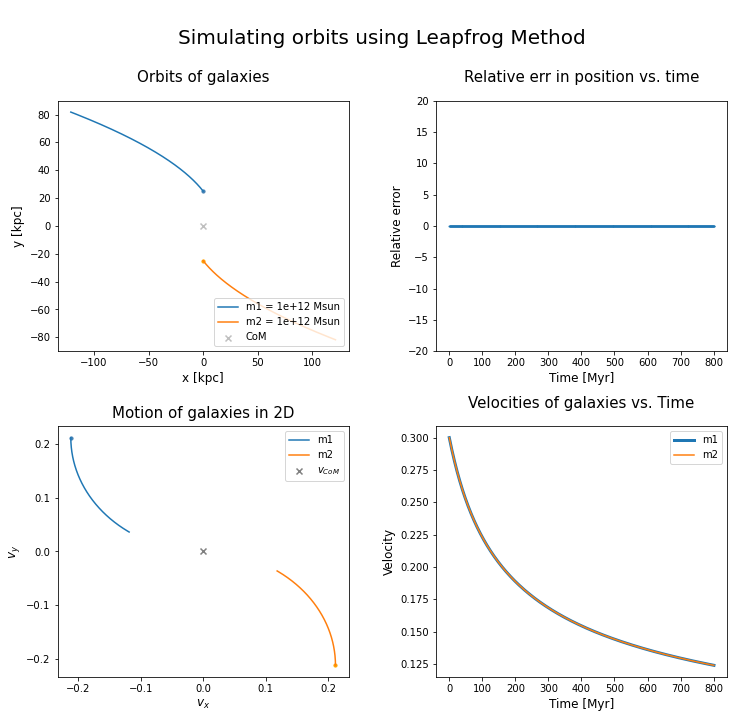

In [43]:
fig = plt.figure(figsize=(12,10))


# paths of m1, m2
plt.subplot(221) # ,aspect='auto')
plt.scatter(0,0, marker='x', color='grey', alpha=0.5, label=r'CoM')
plt.scatter(X[0,0], Y[0,0], s=10, c='steelblue') # initial position
plt.scatter(X[0,1], Y[0,1], s=10, c='orange') # initial position
plt.plot(X[:,0], Y[:,0], label=f"m1 = {m1:.3} Msun")
plt.plot(X[:,1], Y[:,1], label=f"m2 = {m2:.3} Msun")
plt.xlabel("x [kpc]", fontsize=12), plt.ylabel("y [kpc]", fontsize=12)
plt.legend(loc='lower right')
plt.title("Orbits of galaxies", fontsize='15', y=1.05)

# err vs time
plt.subplot(222,aspect='auto')
plt.scatter(t, err, s=1)
plt.ylim(err_tol*np.array([-1,1]))
plt.xlabel("Time [Myr]", fontsize=12), plt.ylabel("Relative error", fontsize=12)
plt.title("Relative err in position vs. time" , fontsize='15', y=1.05)
print(f"cumulative error over {t[-1]} Myr: {err[-1]:.6} .")

# vx vs vy
plt.subplot(223,aspect='auto')
plt.scatter(0,0, marker='x', color='grey', label=r'$v_{CoM}$')
plt.scatter(v_[0,0], v_[0,1], s=10, c='steelblue') # initial velocity
plt.scatter(v_[0,2], v_[0,3], s=10, c='orange') # initial velocity
plt.plot(v_[:,0], v_[:,1], label="m1")
plt.plot(v_[:,2], v_[:,3], label="m2")
plt.title("Motion of galaxies in 2D", fontsize='15', y=1.01)
plt.legend()
plt.xlabel("$v_{x}$", fontsize=12), plt.ylabel("$v_y$", fontsize=12)

# vel vs time
plt.subplot(224,aspect='auto')
plt.plot(t, np.sqrt(v_[:,0]**2 + v_[:,1]**2), lw=3, label="m1" )
plt.plot(t, np.sqrt(v_[:,2]**2 + v_[:,3]**2), label="m2" )
plt.title("Velocities of galaxies vs. Time", fontsize='15', y=1.05)
plt.legend()
plt.xlabel("Time [Myr]", fontsize=12), plt.ylabel("Velocity", fontsize=12)


fig.suptitle("\nSimulating orbits using Leapfrog Method\n", fontsize = '20')
fig.subplots_adjust(hspace=0.3,wspace=0.3,top=0.85,bottom=0.05)


Text(0.5, 1.05, 'Orbits of galaxies')

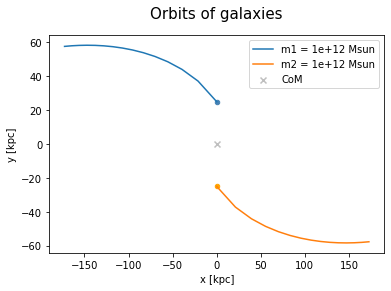

In [22]:

plt.scatter(0,0, marker='x', color='grey', alpha=0.5, label=r'CoM')
plt.scatter(X[0,0], Y[0,0], s=20, c='steelblue') # initial position
plt.scatter(X[0,1], Y[0,1], s=20, c='orange') # initial position
plt.plot(X[:,0], Y[:,0], label=f"m1 = {m1:.3} Msun")
plt.plot(X[:,1], Y[:,1], label=f"m2 = {m2:.3} Msun")

plt.xlabel("x [kpc]"), plt.ylabel("y [kpc]")
plt.legend()
plt.title("Orbits of galaxies", fontsize='15', y=1.05)
